# **Lesson 02**

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

In [63]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

# Exercise 02.1

**1D integral**

- Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

Show a picture of both your estimations of $I$ and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$</font>.

## Solution

To compute integrals using **Monte Carlo**, usually the integrand function $f(x)$ is factorized in a trial function $g(x)$ and a normalized probability distribution $p(x)$. Thus the integral takes the form:

$$ I = \int_\Omega p(x) g(x) dx \ . $$

It can be shown that, if we draw a set of points $x_i$ from the distribution $p(x)$, the integral can be estimated by the quantity:

$$ G_N = \frac{1}{N} \sum_{i=1}^N g(x_i) \ . $$

So one can choose any normalized probability distribution $p(x)$ to calculate the integral, and we have that $\langle G_N \rangle = I$, making us able to evaluate $I$ using the blocking average method.

### Code

To define the integrand function I implemented a virtual class `function` with a method `Eval()` which takes an `arma::vec` (so that the input variable can be multi-dimensional) and evaluates the function, and an operator `()`that calls this method. I then implemented the derived class `cosine`, that is able to evaluate any function of the shape $f(x) = a \cos(bx) + c$.

To compute the blocking average I implemented a new class derived from `BlockingAverage`, called `BA_Integral`.

### Importance Sampling

Importance sampling is a method that consists in a clever choice of the probability distribution we have to sample to calculate the integral. In fact, choosing a probability distribution $d(x)$, which should be normalized and positive in the integration interval, that is similar to the original integrand $f(x)$ the variance of the integral can be greatly reduced. We can easily choose $d(x)$ writing:

$$ I = \int_\Omega f(x) dx = \int_\Omega \frac{f(x)}{d(x)} d(x) dx \ , $$

and so: 

$$I \simeq \frac{1}{N} \sum_{i=1}^N \frac{f(x_i)}{d(x_i)} \ . $$

In the case of the integrand function $f(x) = \frac{\pi}{2}\cos(\pi x/2)$, a good idea to find a good $d(x)$ can be to expand the function (for example with Taylor series) at the first order and to normalize the result. Doing this in $x=0$, however, produces a negative probability distribution, so I tried the expansion in $x=1$, obtaining:

$$ d(x) = 2(1-x) \ . $$

So, I evaluated with data blocking the integral $I$ using this method, at first sampling with a uniform distribution $u(x) = 2x$ in the interval $[0,1]$, and then using $d(x)$.

In [64]:
# import files
unif = np.loadtxt('02.1/unif_sampl.csv', delimiter=',', skiprows=1)
impo = np.loadtxt('02.1/impo_sampl.csv', delimiter=',', skiprows=1)

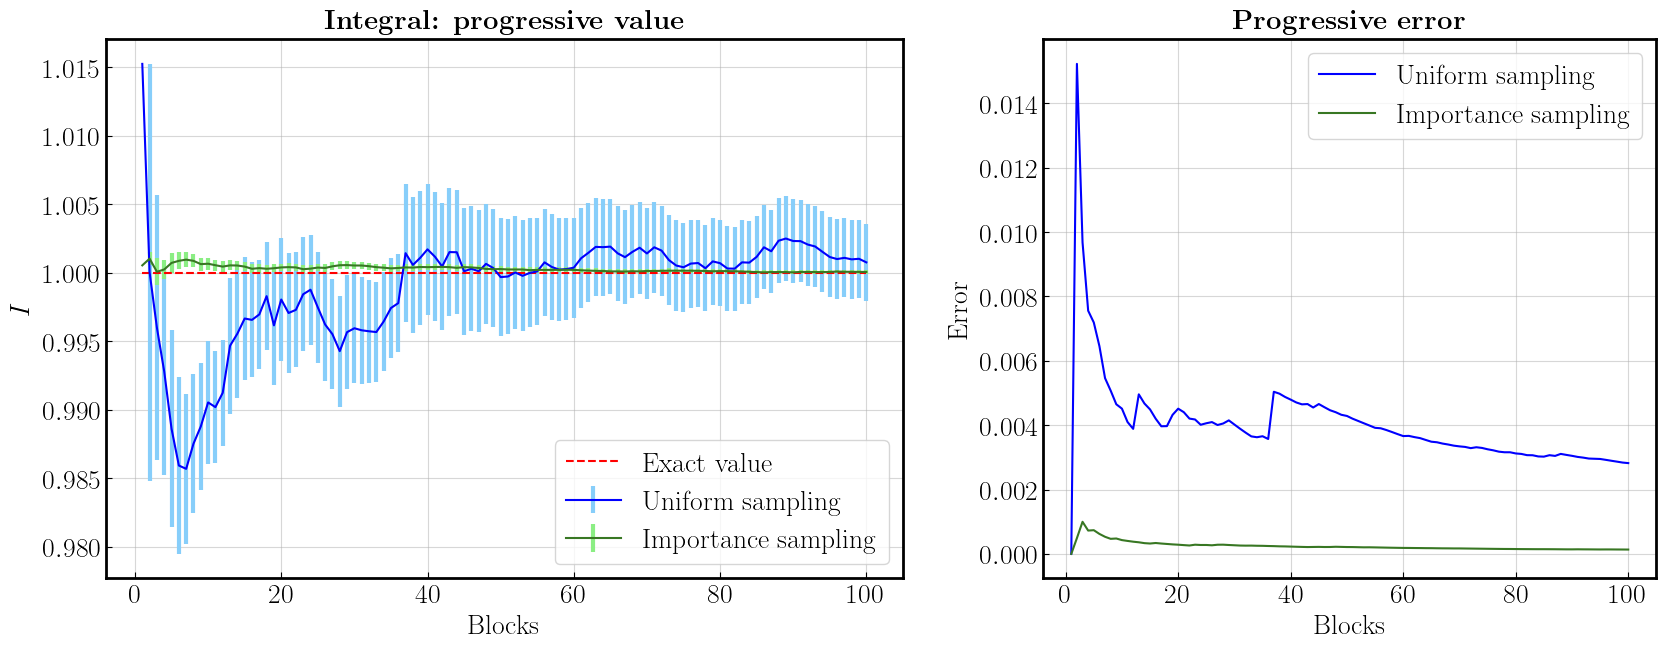

In [73]:
# plots
fig1, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [1.3, 1]})

axs[0].errorbar(unif[:,0], unif[:,2], yerr=unif[:,3], fmt='-', color='blue', ecolor='lightskyblue', elinewidth=3, label='Uniform sampling')
axs[0].errorbar(impo[:,0], impo[:,2], yerr=impo[:,3], fmt='-', color='#387723', ecolor='#8BEE84', elinewidth=3, label='Importance sampling')
one = np.ones(unif.shape[0])
axs[0].plot(unif[:,0], one, linestyle='--', color='red', label='Exact value')


axs[0].set_title(r'\textbf{Integral: progressive value}', pad=8)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel(r'$I$', labelpad=6)
axs[0].legend(loc='lower right')


axs[1].plot(unif[:,0], unif[:,3], color='blue', label='Uniform sampling')
axs[1].plot(impo[:,0], impo[:,3], color='#387723', label='Importance sampling')

axs[1].set_title(r'\textbf{Progressive error}', pad=8)
axs[1].set_xlabel('Blocks')
axs[1].set_ylabel('Error', labelpad=6)
axs[1].legend()

plt.show(fig1)
plt.close(fig1)

This plots show the progressive average value of $I$ with its error and also the progressive value of the error itself, with both uniform sampling and importance sampling. Both these methods give a result compatible with the expectation value of $1$, but the importance sampling error is much smaller: less then a third of the error obtained with Uniform sampling.

**Plot parameters**:
- Extractions: $10^6$
- Blocks: $10^2$
- Extractions in each block: $10^4$

# Exercise 02.2
**3D Random Walks (RW) on a cubic lattice and in the continuum**

Repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$
2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.

Suggestion: divide your $M$ throws into a reasonable number of blocks, compute $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ as function of the step $i\in [0,10^2]$ in each block and use these values (for fixed $i$) to obtain the average value and its statistical uncertainty.

Note that you could try to fit both results with a function like $f(N)=k\sqrt{N}$. Do your results indicate a diffusive behavior?

## Solution

A Random Walk (RW) is a **stochastic process** that models a trajectory with a succession of random steps: it can perform discrete and continuous steps, in any number of dimensions, in discrete or continuous pace. I implemented a Random Walk with discrete step $a$ (fixed at $1$) in three dimensions, both in case of discrete and continuous space.

In a RW, every step depends only on the previous one: this is the fundamental characteristics of a **Markov process**. If seen as a Markov memory-less process, the RW turns out to be a diffusion process: it means that its standard deviation (i.e. the distance from the origin) behaves like $\sqrt{N}$, where $N$ is the number of steps. The aim of this exercise is to verify this fact.

To do this I evaluated the step by step distance from the origin of $10^5$ RWs, each with $10^3$ steps. To measure the distance and its error I used the data blocking technique, dividing the RWs in $100$ blocks of $1^3$ elements each.

### Code
To perform the RW I implemented a class `Walker`, that evolves an `arma::vec pos_` with the dimensionality of the problem (i.e. `dim_`$=3$) performing random steps of fixed length.

To calculate the blocking average I didn't use the virtual class `BlockingAverage`, as I preferred to do the calculations in one single for loop for efficiency and also because doing so I could save one trajectory to plot.

### Discrete lattice

Firstly, I implemented a RW over a **discrete** 3D lattice: to do so I generated random numbers uniformly in the interval $[-$`dim_`,`dim_`$)$, I divided this interval in $2$`dim_` bins, and then I incremented the coordinate of `pos_`corresponding to the bin in which the random number falls.

The following code illustrates this procedure:

```c++
void Walker :: Discrete_Step(double r) {
    if (r < 0 || r >= 1) {
        fmt::print("ERROR! Random number must be in range [0,1)!\n\n");
        exit(0);
    }
    r = 2*dim_*r - dim_;
    for(int i=0 ; i<dim_ ; i++) {
        if(r >= -dim_ + i and r < -dim_ + i + 1) pos_[i] -= step_;
        else if(r >= i and r < i + 1) pos_[i] += step_;
    }
}
```

In [66]:
ddist1 = np.loadtxt('02.2/discrete_distance.csv', delimiter=',', skiprows=1)
ddist = ddist1[:1000,:]

In [67]:
# fit function
def fit_sqrt(x, a) :
    return a * np.sqrt(x)

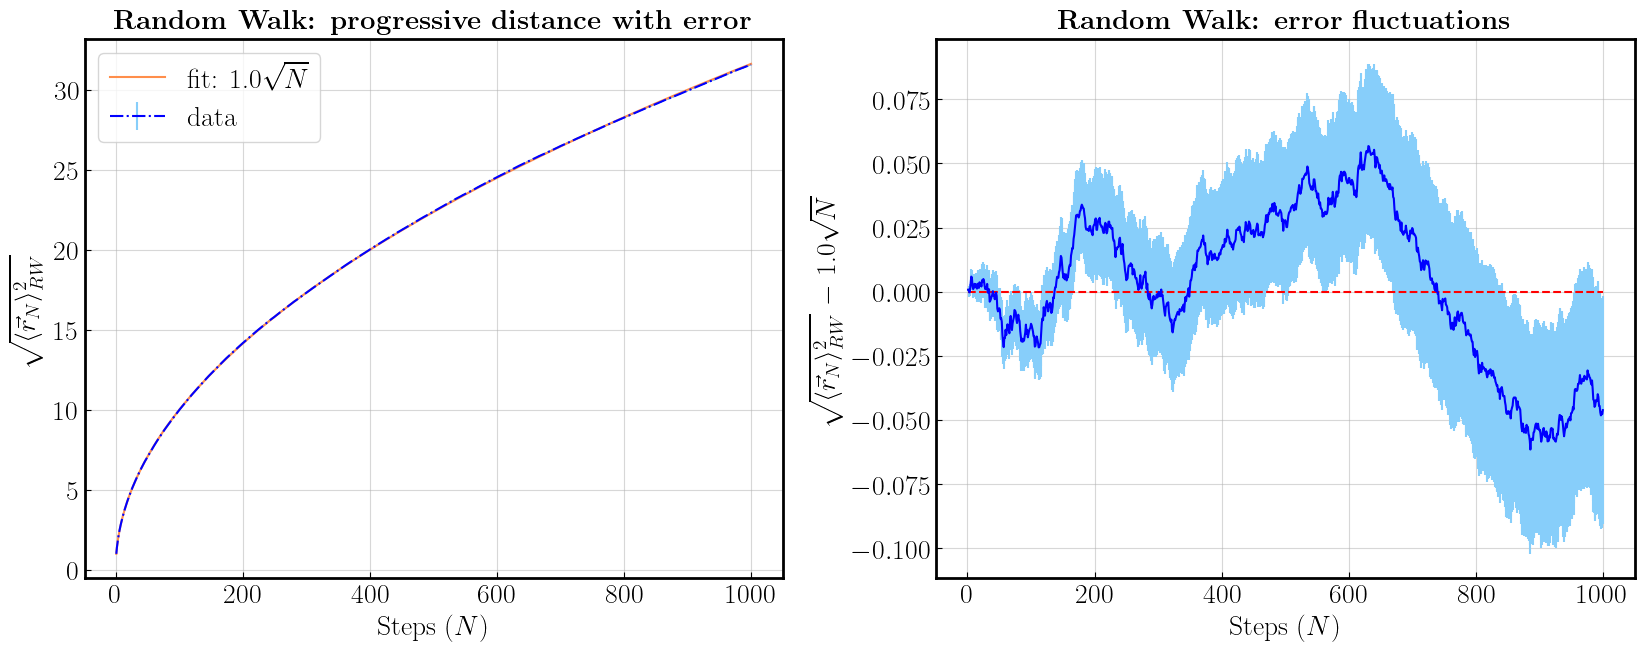

In [68]:
fig2, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'wspace': 0.22})

# plot 1
axs[0].errorbar(ddist[:,0], ddist[:,1], yerr=ddist[:,2], color='blue', linestyle='-.', ecolor='lightskyblue', label='data')
popt, pcov = curve_fit(fit_sqrt, ddist[:,0], ddist[:,1])
dist_fit = fit_sqrt(ddist[:,0], *popt)
axs[0].plot(ddist[:,0], dist_fit, color='#FF8E4B', label='fit: ' + str(np.round(popt[0], 3)) + '$\sqrt{N}$')

axs[0].set_title(r'\textbf{Random Walk: progressive distance with error}', pad=8)
axs[0].set_xlabel('Steps $(N)$')
axs[0].set_ylabel(r'$ \sqrt{\langle \vec{r}_N \rangle^2_{RW}} $', labelpad=8)
axs[0].legend()

# plot 2
axs[1].errorbar(ddist[:,0], ddist[:,1]-dist_fit, yerr=ddist[:,2], color='blue', ecolor='lightskyblue',)
zero = np.zeros(ddist.shape[0])
axs[1].plot(ddist[:,0], zero, c='red', ls='--')

axs[1].set_title(r'\textbf{Random Walk: error fluctuations}', pad=8)
axs[1].set_xlabel('Steps $(N)$')
axs[1].set_ylabel(r'$ \sqrt{\langle \vec{r}_N \rangle^2_{RW}} \ - \ $' + str(np.round(popt[0], 3)) + '$\sqrt{N}$', labelpad=6)

plt.show(fig2)
plt.close(fig2)

The left plot shows the progressive value of the walker distance from the origin with its error, fitted with a square root function. The data arte in excellent agreement with the fit, proving the diffusive behaviour of the RW. On the right there are represented the error fluctuations obtained subtracting the fit from the data points. The zero line falls within at the most $2\sigma$ from the fluctuations.

**Plot parameters**:
- Extractions: $10^5$
- Blocks: $10^2$
- Extractions in each block: $10^3$
- Random Walk steps: $10^3$

In [69]:
dex1 = np.loadtxt('02.2/discrete_example.csv', delimiter=',', skiprows=1)
dex = dex1[:1000,:]

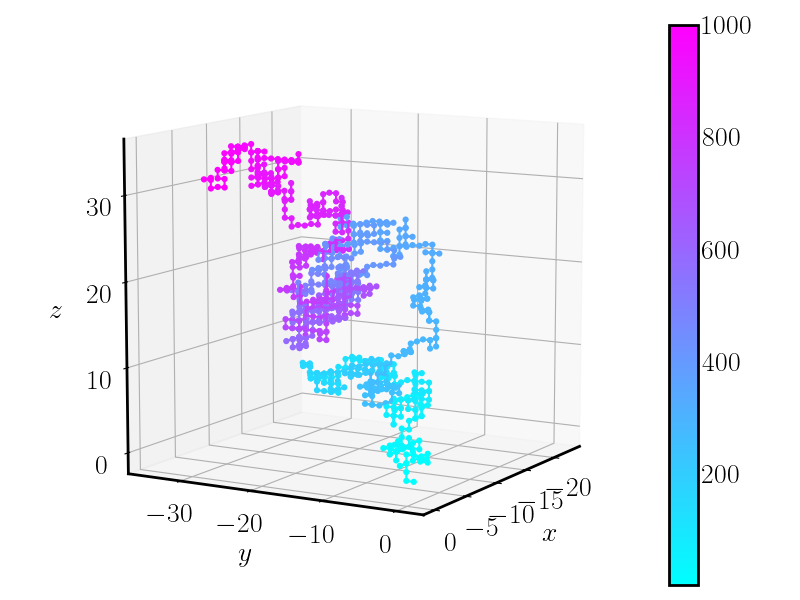

In [78]:
%matplotlib widget
#%matplotlib inline

fig3 = plt.figure()
ax = fig3.add_subplot(projection='3d')
cmap = plt.get_cmap('cool')
colors = cmap(dex[:,0] / dex[:,0].max())
scatter = ax.scatter(dex[:,1], dex[:,2], dex[:,3], c=dex[:,0], cmap=cmap, marker='o', edgecolors='none', alpha=1)
for i in range(1, len(dex)):
    ax.plot(dex[i-1:i+1, 1], dex[i-1:i+1, 2], dex[i-1:i+1, 3], color=colors[i])

ax.view_init(elev=30, azim=45)
ax.set_xlabel('$x$', labelpad=10)
ax.set_ylabel('$y$', labelpad=10)
ax.set_zlabel('$z$', labelpad=10)

fig3.colorbar(scatter)

ax.set_box_aspect([1,1,1])
ax.view_init(10, 30)
fig3.tight_layout()

plt.show(fig3)
#fig3

In [71]:
plt.close(fig3)
%matplotlib inline

No such comm: 43d268567f824b578f53e254ce6134f9
No such comm: 43d268567f824b578f53e254ce6134f9
No such comm: 43d268567f824b578f53e254ce6134f9
No such comm: 43d268567f824b578f53e254ce6134f9
No such comm: 43d268567f824b578f53e254ce6134f9
No such comm: 43d268567f824b578f53e254ce6134f9
No such comm: 43d268567f824b578f53e254ce6134f9


Here I show an example of trajectory in discrete space, the color map follows the number of steps.

## Continue random walk

In the case of a continuum space, the RW can move not only in the sites of a cubic lattice, but each step can be done in any direction (but always with fixed length). The problem was how to **uniformly sample a solid angle** to choose the direction of the steps.

In fact, if we extract according to a uniform distribution both the polar angle $\phi \in [0,2\pi)$ and the azimuthal angle $\theta \in [0,\pi)$, we wouldn't obtain a uniform distribution on the sphere, because for values of $\theta$ near to $0$ or $\pi$ (that have the same probability as $\pi/2$ to be sampled if we choose a uniform distribution) we will have many points clustered at the poles, no matter what polar angle $\phi$ they have, while near the equator points will be more scattered.

To resolve this problem it can be observed that what really should be uniformly sampled is not $\theta$, but $\frac{1}{2}\sin(\theta)$, leaving $\phi$ uniformly distributed. In fact we have, for a uniform probability distribution $u=1/4\pi$ in spherical coordinates:

$$ 1 = \int_0^{2\pi} \int_0^\pi \frac{1}{4\pi} \sin(\theta) d\theta d\phi = \int_0^\pi \frac{1}{2} \left( \int_0^{2\pi} \frac{1}{2\pi} d\phi \right) \sin(\theta) d\theta = \int_0^\pi \frac{1}{2} \sin(\theta) d\theta \ . $$

So I used the **cumulative inverse method** to sample $p(\theta) = \frac{1}{2}\sin(\theta)$, with $\theta \in [0,\pi)$, whose cumulative function is:

$$ F(\theta) = \frac{1}{2}(\cos(\theta) - 1) =: y \ . $$

Finally, inverting this cumulative function, I obtained: 
$$ \theta = \arccos(1 - 2y) \ . $$

The following code illustrates the sampling of angles for the step in continue space:

```c++
void Walker :: Continue_Step(double the, double phi) {
    if(dim_ != 3) {
        fmt::print("ERROR! Spherical coordinate step must be in 3D!\n\n");
        exit(0);
    }
    if (the < 0 || the >= 1 || phi < 0 || phi >= 1 ) {
        fmt::print("ERROR! Random number must be in range [0,1)!\n\n");
        exit(0);
    }
    double theta = std::acos(1 - 2*the);
    phi *= 2*M_PI;

    pos_[0] += step_ * std::sin(theta) * std::cos(phi);
    pos_[1] += step_ * std::sin(theta) * std::sin(phi);
    pos_[2] += step_ * std::cos(theta);
}
```

In [74]:
cdist1 = np.loadtxt('02.2/continue_distance.csv', delimiter=',', skiprows=1)
cdist = cdist1[:1000,:]

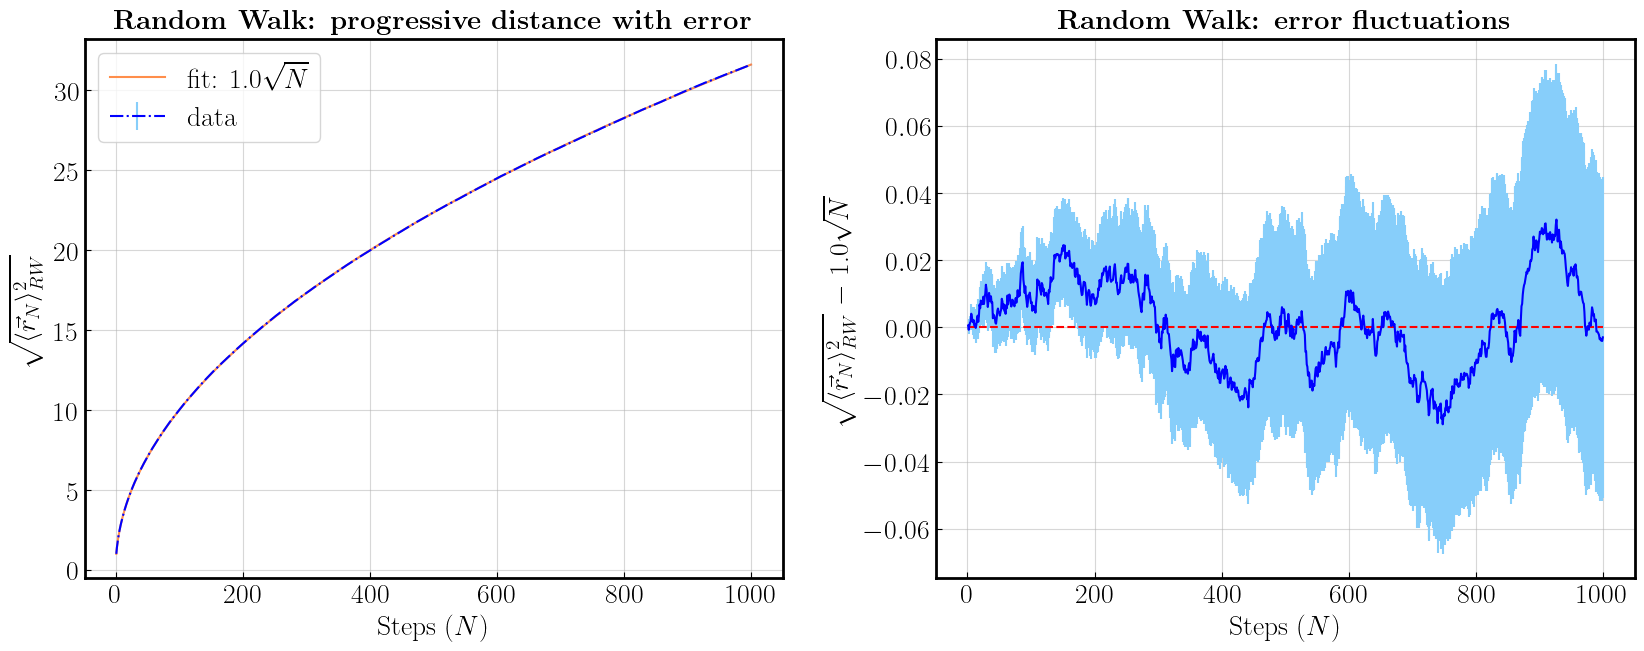

In [75]:
fig4, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'wspace': 0.22})

# plot 1
axs[0].errorbar(cdist[:,0], cdist[:,1], yerr=cdist[:,2], color='blue', linestyle='-.', ecolor='lightskyblue', label='data')
popt, pcov = curve_fit(fit_sqrt, cdist[:,0], cdist[:,1])
dist_fit = fit_sqrt(cdist[:,0], *popt)
axs[0].plot(cdist[:,0], dist_fit, color='#FF8E4B', label='fit: ' + str(np.round(popt[0], 3)) + '$\sqrt{N}$')

axs[0].set_title(r'\textbf{Random Walk: progressive distance with error}', pad=8)
axs[0].set_xlabel('Steps $(N)$')
axs[0].set_ylabel(r'$ \sqrt{\langle \vec{r}_N \rangle^2_{RW}} $', labelpad=8)
axs[0].legend()

# plot 2
axs[1].errorbar(cdist[:,0], cdist[:,1]-dist_fit, yerr=cdist[:,2], color='blue', ecolor='lightskyblue',)
zero = np.zeros(cdist.shape[0])
axs[1].plot(cdist[:,0], zero, c='red', ls='--')

axs[1].set_title(r'\textbf{Random Walk: error fluctuations}', pad=8)
axs[1].set_xlabel('Steps $(N)$')
axs[1].set_ylabel(r'$ \sqrt{\langle \vec{r}_N \rangle^2_{RW}} \ - \ $' + str(np.round(popt[0], 3)) + '$\sqrt{N}$', labelpad=6)

plt.show(fig4)
plt.close(fig4)


The left plot shows the progressive value of the walker distance from the origin with its error, fitted with a square root function. The data are in excellent agreement with the fit, proving the diffusive behaviour of the RW. On the right there are represented the error fluctuations obtained subtracting the fit from the data points. The zero line falls within $\sigma$ from the fluctuations.

**Plot parameters**:
- Extractions: $10^5$
- Blocks: $10^2$
- Extractions in each block: $10^3$
- Random Walk steps: $10^3$

In [76]:
cex1 = np.loadtxt('02.2/continue_example.csv', delimiter=',', skiprows=1)
cex = cex1[:1000,:]

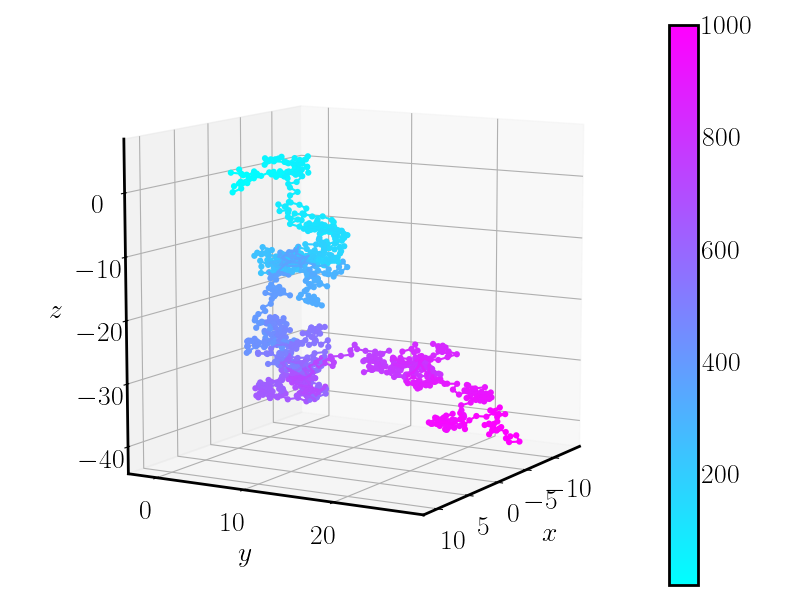

In [77]:
%matplotlib widget

fig5 = plt.figure()
ax = fig5.add_subplot(projection='3d')
cmap = plt.get_cmap('cool')
colors = cmap(cex[:,0] / cex[:,0].max())
scatter = ax.scatter(cex[:,1], cex[:,2], cex[:,3], c=cex[:,0], cmap=cmap, marker='o', edgecolors='none', alpha=1)
for i in range(1, len(cex)):
    ax.plot(cex[i-1:i+1, 1], cex[i-1:i+1, 2], cex[i-1:i+1, 3], color=colors[i])

ax.view_init(elev=30, azim=45)
ax.set_xlabel('$x$', labelpad=10)
ax.set_ylabel('$y$', labelpad=10)
ax.set_zlabel('$z$', labelpad=10)

fig5.colorbar(scatter)

ax.set_box_aspect([1,1,1])
ax.view_init(10, 30)
fig5.tight_layout()

plt.show(fig5)

Here I show an example of trajectory in continue space, the color map follows the number of steps.

In [ ]:
plt.close(fig5)
%matplotlib inline